# Goodness of Fit and Model Comparison


## Goodness of fit
It is often that we we need to know how well our model fits our data. While in  linear, Gaussian regimes and under certain regularity conditions, the reduced $\chi^2$ provides a measure of fit quality, most of the time it is unreliable and incorrect to use. For more on this, read [The Do's and Don'ts of reduced chi2](https://arxiv.org/pdf/1012.3754.pdf).

Instead, we can [almost](www.google.com) always use the bootstrap method to estimate the quality of an MLE analysis. In 3ML, we can do this with the quite simply after a fit.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context='talk', fscale=1, ticks=True, grid=False)
plt.style.use('mike')

import scipy.stats as stats
import numpy as np

from threeML import *

import warnings
warnings.simplefilter('ignore')

Let's go back to simulations. We will simulate a straight line. 

Using Gaussian statistic (equivalent to chi^2) with the provided errors.


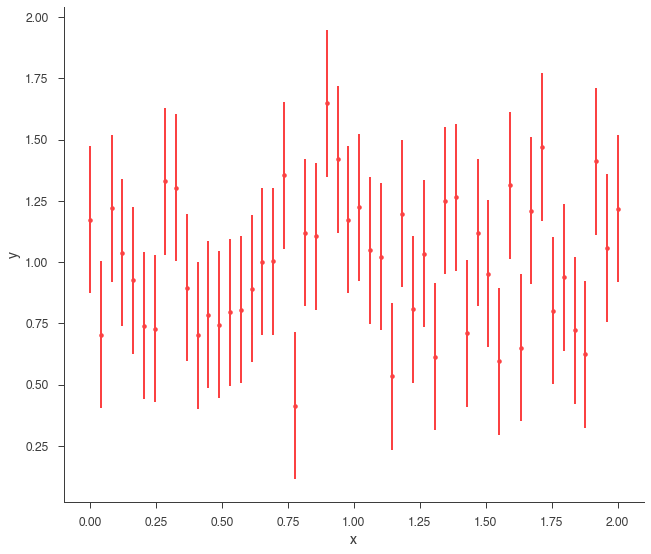

In [5]:
gen_function = Line(a=0,b=1)

x = np.linspace(0, 2, 50)

xyl_generator = XYLike.from_function("sim_data", function = gen_function, 
                                     x = x, 
                                     yerr = 0.3 * gen_function(x))

y = xyl_generator.y
y_err = xyl_generator.yerr

xyl_generator.plot();



So, now we simply need to fit the data. 

Using Gaussian statistic (equivalent to chi^2) with the provided errors.
Best fit values:



,result,unit
parameter,,
xyl.spectrum.main.Line.a,(3 +/- 7) x 10^-2,1 / (cm2 keV2 s)
xyl.spectrum.main.Line.b,(9.6 +/- 0.8) x 10^-1,1 / (cm2 keV s)



Correlation matrix:



1.00,-0.86
-0.86,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
data,21.023393
total,21.023393



Values of statistical measures:



,statistical measures
AIC,46.302106
BIC,49.870833


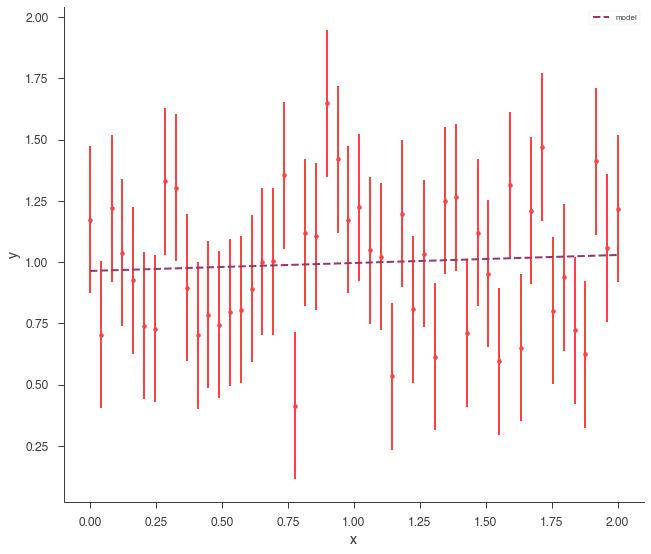

In [6]:
fit_function = Line()

xyl = XYLike("data", x, y, y_err)

datalist = DataList(xyl)

model = Model(PointSource('xyl',0,0,spectral_shape=fit_function))

jl = JointLikelihood(model, datalist)

jl.fit();

xyl.plot();


Now that the data are fit, we can assess the goodness of fit via simulating synthetic data sets and seeing how often these datasets have a similar likelihood. To do this, pass the JointLikelihood object to the GoodnessOfFit class.

In [7]:
gof_obj = GoodnessOfFit(jl)

Now we will monte carlo some datasets. This can be computationally expensive, so we will use 3ML's built in context manager for accessing ipython clusters. If we have a profile that is connected to a super computer, then we can simulate and fit all the datasets very quickly. 

In [9]:
with parallel_computation():
    gof, data_frame, like_data_frame = gof_obj.by_mc(n_iterations=8000)

Starting ipyparallel cluster with this command line:
/Users/jburgess/.environs/3ml/bin/ipcluster start
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
12 engines are active



Shutting down ipcluster...


Three things are returned, the GOF for each plugin (in our case one) as well as the total GOF, a data frame with the fitted values for each synthetic dataset, and the likelihoods for all the fits. We can see that the data have a reasonable GOF:

In [10]:
gof

OrderedDict([('total', 0.712625), ('data', 0.712625)])

## Likelihood Ratio Tests

An essential part of MLE analysis is the likelihood ratio test (LRT) for comparing models. For **nested models** (those where one is a special case of the other), [Wilks' theorem](https://projecteuclid.org/euclid.aoms/1177732360) posits that the LRT is $\chi^2$ distributed, and thus the null model can be rejected with a probability read from a $\chi^2$ table. 

In a perfect world, this would always hold, but there are many regualrity conditions on Wilks' theorem that are often violated in astromonical data. For a review, see [Protassov et al](http://iopscience.iop.org/0004-637X/571/1/545/) and keep it close at heart whenever wanting to use the LRT. 

For these reasons, in 3ML we provide a method for computing the LRT via profiling the null model via bootstrap samples. This is valid for nested models and avoids the dangers of asymmptotics and parameters defined on the extreme boundries of their distributions (spectral line normalizations, extra spectral components, etc.). This method does not avoid other problems which may arise from systmatics present in the data. As with any analysis, it is important to doubt and try and prove the result wrong as well as understanding the data/instrument.

Let's start by simulating some data from a power law with an exponential cutoff on top of a background.


In [11]:
energies = np.logspace(1,3,51)

low_edge = energies[:-1]
high_edge = energies[1:]

# get a blackbody source function
source_function = Cutoff_powerlaw(K=1,index=-1,xc=300,piv=100)

# power law background function
background_function = Powerlaw(K=1,index=-2., piv=100.)

spectrum_generator = SpectrumLike.from_function('fake',
                                               source_function=source_function,
                                               background_function=background_function,
                                               energy_min=low_edge,
                                               energy_max=high_edge)



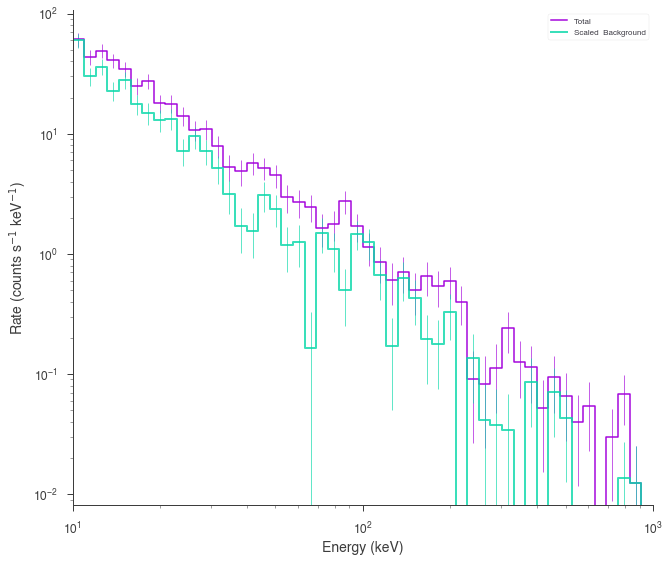

In [13]:
spectrum_generator.view_count_spectrum();

We simulated a weak cutoff powerlaw. But if this was real data, we wouldn't know that there was a cutoff. So we would fit both a power law (the null model) and a cutoff power law (the alternative model).

Let's setup two models to fit the data via MLE in the standard 3ML way.

In [14]:
powerlaw = Powerlaw(piv=100)
cutoff_powerlaw = Cutoff_powerlaw(piv=100)

ps_powerlaw = PointSource('test_pl', 0, 0 , spectral_shape=powerlaw)
ps_cutoff_powerlaw = PointSource('test_cpl', 0, 0, spectral_shape=cutoff_powerlaw)

model_null = Model(ps_powerlaw)
model_alternative = Model(ps_cutoff_powerlaw)

In [15]:
datalist = DataList(spectrum_generator)

In [16]:
jl_null = JointLikelihood(model_null,datalist)
jl_null.fit();

Best fit values:



,result,unit
parameter,,
test_pl.spectrum.main.Powerlaw.K,(5.7 -0.6 +0.7) x 10^-1,1 / (cm2 keV s)
test_pl.spectrum.main.Powerlaw.index,-1.55 +/- 0.07,



Correlation matrix:



1.00,0.32
0.32,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
fake,207.424608
total,207.424608



Values of statistical measures:



,statistical measures
AIC,419.104535
BIC,422.673262


In [17]:
jl_alternative = JointLikelihood(model_alternative,datalist)
jl_alternative.fit();

Best fit values:



,result,unit
parameter,,
test_cpl.spectrum.main.Cutoff_powerlaw.K,(8.6 -1.8 +2.2) x 10^-1,1 / (cm2 keV s)
test_cpl.spectrum.main.Cutoff_powerlaw.index,-1.28 +/- 0.16,
test_cpl.spectrum.main.Cutoff_powerlaw.xc,(5.0 -2.2 +4) x 10^2,keV



Correlation matrix:



1.00,0.83,-0.90
0.83,1.00,-0.85
-0.90,-0.85,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
fake,205.630008
total,205.630008



Values of statistical measures:



,statistical measures
AIC,417.781755
BIC,422.996084


Ok, we now have our log(likelihoods) from each model. If we took Wilks' theorem to heart, then we would compute:

$$\Lambda(x)=\frac{\sup\{\,\mathcal L(\theta\mid x):\theta\in\Theta_0\,\}}{\sup\{\,\mathcal L(\theta\mid x) : \theta\in\Theta\,\}}$$

or $-2 \log(\Lambda)$ which would be $\chi^2_{\nu}$ distributed where $\nu$ is the number of extra parameters in the alternative model. In our case:


In [18]:
# calculate the test statistic
TS = 2*(jl_null.results.get_statistic_frame()['-log(likelihood)']['total'] - jl_alternative.results.get_statistic_frame()['-log(likelihood)']['total'])

print('null hyp. prob.: %f' %stats.chi2.pdf(TS,1))


null hyp. prob.: 0.034997


But lets check this by simulating the null distribution.

We create a LRT object by passing the null model and the alternative model (in that order).

In [19]:
lrt = LikelihoodRatioTest(jl_null,jl_alternative)

Now we MC synthetic datasets again.

In [20]:
with parallel_computation():
    lrt_results = lrt.by_mc(8*600)

Starting ipyparallel cluster with this command line:
/Users/jburgess/.environs/3ml/bin/ipcluster start
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
12 engines are active



Shutting down ipcluster...


This returns three things, the null hypothesis probability, the test statistics for all the data sets, and the fitted values. We see that our null hyp. prob is:

In [21]:
lrt.null_hypothesis_probability

0.052083333333333336

which is slightly different from what we obtained analytically.

We can visualize why by plotting the distributions of TS and seeing if it follows a $\chi^2_{1}$ distribution/

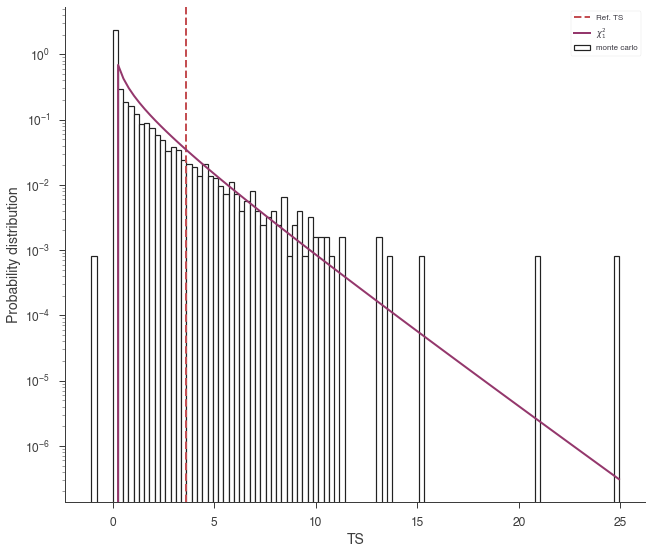

In [27]:
lrt.plot_TS_distribution(bins=100, ec='k',fc='white',lw=1.2);
plt.legend()

The curve is slightly higher than we expect. Let's rescale the curve by 1/2:

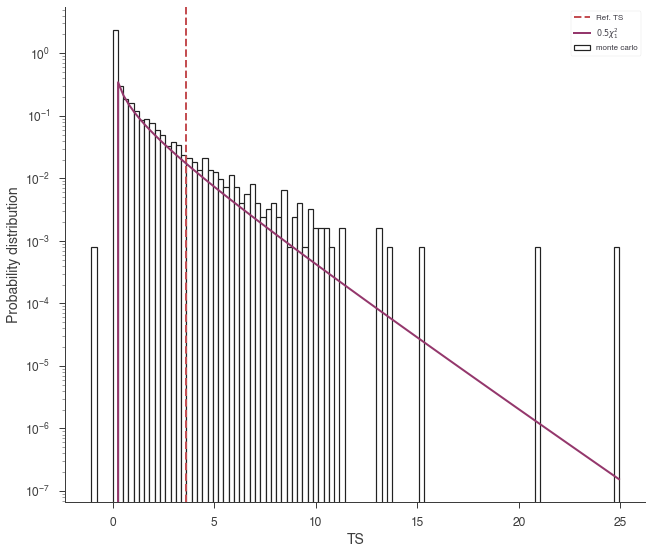

In [28]:
lrt.plot_TS_distribution(scale=0.5,bins=100,ec='k',fc='white',lw=1.2);
plt.legend()

Thus, we see that 3ML provides an automatic, and possibly efficient way to avoid the nasty problems of the LRT.

Both the GoodnessOfFit and LikelihoodRatioTest classes internally handle the generation of synthetic datasets. All current plugins have the ability to generate synthetic datasets based off their internal properties such as their background spectra and instrument responses.